## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from xgboost import XGBClassifier

## Import data

In [2]:
df=pd.read_csv('COGNITIVE DISTORTION DATASET IN ENGLISH COMPLETE.csv')

df.head()

,TEXT (BAHASA),TEXT (ENGLISH),DATA STATUS,FIRST ANNOTATOR,SECOND ANNOTATOR
0,ketika saya sudah berusaha semaksimal mungkin ...,when I have tried my best but am still not opt...,RAW-ORI,All-or-nothing,All-or-nothing
1,Saya ketika SD hingga SMP dulu beranggapan bah...,When I was in elementary school to middle scho...,RAW-ORI,All-or-nothing,All-or-nothing
2,Saya berfikir jika tidak lolos MBKM maka masa ...,I thought that if I didn't pass MBKM then my f...,RAW-ORI,All-or-nothing,All-or-nothing
3,"Di desa saya dulu ada dua kelompok pertemanan,...",In my village there were two friendship groups...,RAW-ORI,All-or-nothing,All-or-nothing
4,Saya hanya berteman dengan orang yang tidak me...,I only make friends with people who don't hurt...,RAW-ORI,All-or-nothing,All-or-nothing


In [3]:
df=df.drop(["TEXT (BAHASA)","DATA STATUS"],axis=1)

In [4]:
df.shape[0]

4992

In [5]:
df.head()

,TEXT (ENGLISH),FIRST ANNOTATOR,SECOND ANNOTATOR
0,when I have tried my best but am still not opt...,All-or-nothing,All-or-nothing
1,When I was in elementary school to middle scho...,All-or-nothing,All-or-nothing
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing,All-or-nothing
3,In my village there were two friendship groups...,All-or-nothing,All-or-nothing
4,I only make friends with people who don't hurt...,All-or-nothing,All-or-nothing


In [6]:
df["FIRST ANNOTATOR"].unique()

array(['All-or-nothing', 'Discounting the positives',
       'Emotional Reasoning', 'Fortune-telling', 'Labeling',
       'Magnification or Minimization', 'Mental filter', 'Mind Reading',
       'Overgeneralization', 'Personalization and Blame',
       'Should statement', 'No Distortion'], dtype=object)

In [7]:
# Count entries per class
class_counts = df["FIRST ANNOTATOR"].value_counts()

print(class_counts)


FIRST ANNOTATOR
No Distortion                    2246
Labeling                          390
Mind Reading                      385
Should statement                  371
Personalization and Blame         284
Discounting the positives         241
Overgeneralization                215
All-or-nothing                    200
Emotional Reasoning               200
Magnification or Minimization     200
Mental filter                     200
Fortune-telling                    60
Name: count, dtype: int64


In [8]:
df.isna().sum()

TEXT (ENGLISH)      0
FIRST ANNOTATOR     0
SECOND ANNOTATOR    0
dtype: int64

## Preprocessing

In [9]:
# Remove 'Fortune-telling' rows
df = df[df['FIRST ANNOTATOR'] != 'Fortune-telling']

Removed distortion type with very few instances

In [10]:
df = df[['TEXT (ENGLISH)', 'FIRST ANNOTATOR']]
df.columns = ['text', 'label']

### Clean text

# Text cleaning
import spacy

# Load English model once
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # we only need tokenizer + tagger

def preprocess(text):
    # Basic cleanup
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Process with spaCy
    doc = nlp(text)
    
    # Keep lemmas of non-stop, non-punct tokens, optionally keep negations
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_.strip() != ''
    ]
    
    return ' '.join(tokens)


In [11]:
# Text cleaning
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Binary classification to detect distortion

In [249]:
df_bin = df.copy()
df_bin['binary_label'] = df_bin['label'].apply(lambda x: 0 if x == 'No Distortion' else 1)


In [250]:
df_bin.head()

,text,label,binary_label
0,when I have tried my best but am still not opt...,All-or-nothing,1
1,When I was in elementary school to middle scho...,All-or-nothing,1
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing,1
3,In my village there were two friendship groups...,All-or-nothing,1
4,I only make friends with people who don't hurt...,All-or-nothing,1


After SMOTE: [2148 2148]
----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       449
           1       0.71      0.74      0.72       538

    accuracy                           0.69       987
   macro avg       0.69      0.69      0.69       987
weighted avg       0.69      0.69      0.69       987

----- Random Forest -----
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       449
           1       0.71      0.70      0.70       538

    accuracy                           0.68       987
   macro avg       0.68      0.68      0.68       987
weighted avg       0.68      0.68      0.68       987

----- SVC -----
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       449
           1       0.74      0.74      0.74       538

    accuracy                           0.71       987
   macro avg       0.71      

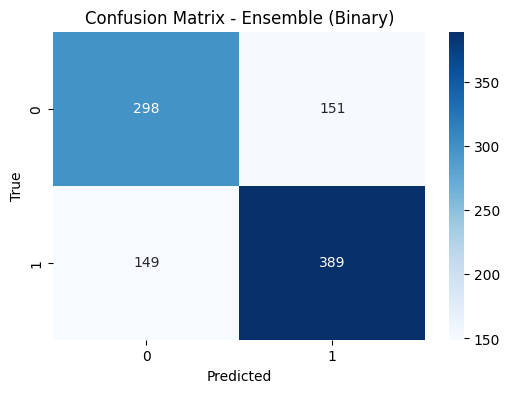

In [251]:
df_bin['text'] = df_bin['text'].apply(preprocess)

# ---------- Train-test split ----------
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    df_bin['text'], df_bin['binary_label'],
    test_size=0.2, random_state=42, stratify=df_bin['binary_label']
)

# ---------- TF-IDF ----------
vectorizer_bin = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=2,
    max_df=0.9,
    lowercase=False
)
X_train_bin_vec = vectorizer_bin.fit_transform(X_train_bin)
X_test_bin_vec = vectorizer_bin.transform(X_test_bin)

# ---------- Dimensionality Reduction ----------
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_bin_vec = svd.fit_transform(X_train_bin_vec)
X_test_bin_vec = svd.transform(X_test_bin_vec)

# ---------- SMOTE Oversampling ----------
smote = SMOTE(random_state=42)
X_train_bin_res, y_train_bin_res = smote.fit_resample(X_train_bin_vec, y_train_bin)
print(f"After SMOTE: {np.bincount(pd.Series(y_train_bin_res).factorize()[0])}")

# ---------- Logistic Regression ----------
clf_lr_bin = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0)
clf_lr_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_lr = clf_lr_bin.predict(X_test_bin_vec)
print("----- Logistic Regression -----")
print(classification_report(y_test_bin, y_pred_bin_lr))

# ---------- Random Forest ----------
clf_rf_bin = RandomForestClassifier(
    n_estimators=300, max_depth=None, class_weight='balanced_subsample', random_state=42
)
clf_rf_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_rf = clf_rf_bin.predict(X_test_bin_vec)
print("----- Random Forest -----")
print(classification_report(y_test_bin, y_pred_bin_rf))

# ---------- Support Vector Machine ----------
clf_svc_bin = SVC(kernel='rbf', C=2.0, probability=True, class_weight='balanced', random_state=42)
clf_svc_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_svc = clf_svc_bin.predict(X_test_bin_vec)
print("----- SVC -----")
print(classification_report(y_test_bin, y_pred_bin_svc))

# ---------- XGBoost ----------
le_bin = LabelEncoder()
y_train_bin_enc = le_bin.fit_transform(y_train_bin_res)
y_test_bin_enc = le_bin.transform(y_test_bin)

clf_xgb_bin = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb_bin.fit(X_train_bin_res, y_train_bin_enc)
y_pred_bin_xgb_enc = clf_xgb_bin.predict(X_test_bin_vec)
y_pred_bin_xgb = le_bin.inverse_transform(y_pred_bin_xgb_enc)
print("----- XGBoost -----")
print(classification_report(y_test_bin, y_pred_bin_xgb))

# ---------- Voting Ensemble ----------
ensemble_bin = VotingClassifier(
    estimators=[
        ('lr', clf_lr_bin),
        ('rf', clf_rf_bin),
        ('svc', clf_svc_bin),
        ('xgb', clf_xgb_bin)
    ],
    voting='soft'  # soft uses predicted probabilities for smoother consensus
)
ensemble_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_ens = ensemble_bin.predict(X_test_bin_vec)

print("----- Ensemble (Soft Voting) -----")
print(classification_report(y_test_bin, y_pred_bin_ens))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_bin, y_pred_bin_ens)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_bin.classes_, yticklabels=le_bin.classes_)
plt.title("Confusion Matrix - Ensemble (Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Multiclass classification to detect type of distortion

In [252]:
df_mult=df.copy()
df_mult = df_mult[df_mult['label'] != 'No Distortion']

In [253]:
df_mult.head()

,text,label
0,when I have tried my best but am still not opt...,All-or-nothing
1,When I was in elementary school to middle scho...,All-or-nothing
2,I thought that if I didn't pass MBKM then my f...,All-or-nothing
3,In my village there were two friendship groups...,All-or-nothing
4,I only make friends with people who don't hurt...,All-or-nothing


After SMOTE: [312 312 312 312 312 312 312 312 312 312]
----- Logistic Regression (Multiclass) -----
                               precision    recall  f1-score   support

               All-or-nothing       0.66      0.68      0.67        40
    Discounting the positives       0.73      0.79      0.76        48
          Emotional Reasoning       0.82      0.82      0.82        40
                     Labeling       0.70      0.56      0.62        78
Magnification or Minimization       0.60      0.65      0.63        40
                Mental filter       0.82      0.80      0.81        40
                 Mind Reading       0.70      0.74      0.72        77
           Overgeneralization       0.65      0.79      0.72        43
    Personalization and Blame       0.68      0.81      0.74        57
             Should statement       0.97      0.76      0.85        75

                     accuracy                           0.73       538
                    macro avg       0.73      

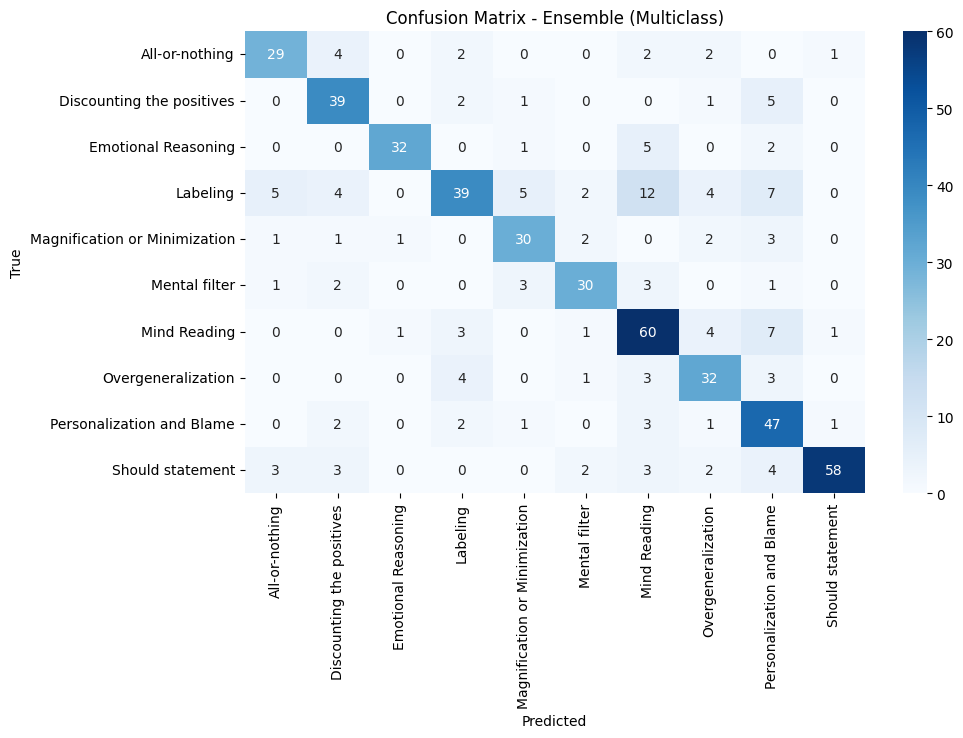

In [254]:
df_mult['text'] = df_mult['text'].apply(preprocess)

# ---------- Train-test split ----------
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
    df_mult['text'], df_mult['label'],
    test_size=0.2, random_state=42, stratify=df_mult['label']
)

# ---------- TF-IDF ----------
vectorizer_mult = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=2,
    max_df=0.9,
    lowercase=False
)
X_train_mult_vec = vectorizer_mult.fit_transform(X_train_mult)
X_test_mult_vec = vectorizer_mult.transform(X_test_mult)

# ---------- Dimensionality Reduction ----------
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_mult_vec = svd.fit_transform(X_train_mult_vec)
X_test_mult_vec = svd.transform(X_test_mult_vec)

# ---------- SMOTE Oversampling ----------
smote = SMOTE(random_state=42)
X_train_mult_res, y_train_mult_res = smote.fit_resample(X_train_mult_vec, y_train_mult)
print(f"After SMOTE: {np.bincount(pd.Series(y_train_mult_res).factorize()[0])}")

# ---------- Logistic Regression ----------
clf_lr_mult = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0, random_state=42)
clf_lr_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_lr = clf_lr_mult.predict(X_test_mult_vec)
print("----- Logistic Regression (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_lr))

# ---------- Random Forest ----------
clf_rf_mult = RandomForestClassifier(
    n_estimators=300, max_depth=None, class_weight='balanced_subsample', random_state=42
)
clf_rf_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_rf = clf_rf_mult.predict(X_test_mult_vec)
print("----- Random Forest (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_rf))

# ---------- Support Vector Machine ----------
clf_svc_mult = SVC(kernel='rbf', C=2.0, probability=True, class_weight='balanced', random_state=42)
clf_svc_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_svc = clf_svc_mult.predict(X_test_mult_vec)
print("----- SVC (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_svc))

# ---------- XGBoost ----------
le_mult = LabelEncoder()
y_train_mult_enc = le_mult.fit_transform(y_train_mult_res)
y_test_mult_enc = le_mult.transform(y_test_mult)

clf_xgb_mult = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='mlogloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb_mult.fit(X_train_mult_res, y_train_mult_enc)
y_pred_mult_xgb_enc = clf_xgb_mult.predict(X_test_mult_vec)
y_pred_mult_xgb = le_mult.inverse_transform(y_pred_mult_xgb_enc)
print("----- XGBoost (Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_xgb))

# ---------- Voting Ensemble ----------
ensemble_mult = VotingClassifier(
    estimators=[
        ('lr', clf_lr_mult),
        ('rf', clf_rf_mult),
        ('svc', clf_svc_mult),
        ('xgb', clf_xgb_mult)
    ],
    voting='soft'
)
ensemble_mult.fit(X_train_mult_res, y_train_mult_res)
y_pred_mult_ens = ensemble_mult.predict(X_test_mult_vec)
print("----- Ensemble (Soft Voting, Multiclass) -----")
print(classification_report(y_test_mult, y_pred_mult_ens))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_mult, y_pred_mult_ens)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_mult.classes_, yticklabels=le_mult.classes_)
plt.title("Confusion Matrix - Ensemble (Multiclass)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Using SBERT embeddings instead of TF-IDF

Batches:   0%|          | 0/124 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

After SMOTE: [2148 2148]
----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       449
           1       0.71      0.69      0.70       538

    accuracy                           0.67       987
   macro avg       0.67      0.67      0.67       987
weighted avg       0.68      0.67      0.68       987

----- Random Forest -----
              precision    recall  f1-score   support

           0       0.64      0.59      0.62       449
           1       0.68      0.73      0.70       538

    accuracy                           0.67       987
   macro avg       0.66      0.66      0.66       987
weighted avg       0.66      0.67      0.66       987

----- SVC -----
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       449
           1       0.73      0.78      0.75       538

    accuracy                           0.72       987
   macro avg       0.72      

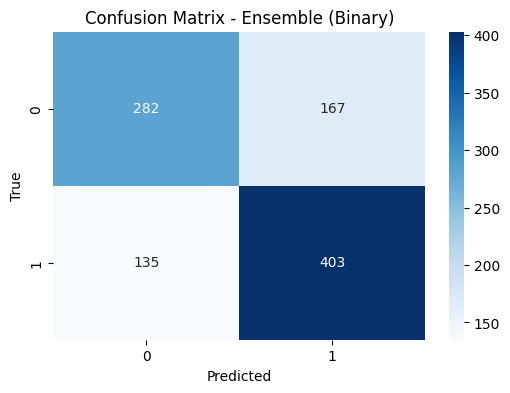

In [12]:
from sentence_transformers import SentenceTransformer

df_bin = df.copy()
df_bin['binary_label'] = df_bin['label'].apply(lambda x: 0 if x == 'No Distortion' else 1)

df_bin['text'] = df_bin['text'].apply(preprocess)

# ---------- Train-test split ----------
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    df_bin['text'], df_bin['binary_label'],
    test_size=0.2, random_state=42, stratify=df_bin['binary_label']
)

# ---------- Sentence Embeddings (SBERT) ----------
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # fast and small
X_train_bin_emb = sbert_model.encode(list(X_train_bin), show_progress_bar=True)
X_test_bin_emb = sbert_model.encode(list(X_test_bin), show_progress_bar=True)

# ---------- SMOTE Oversampling ----------
smote = SMOTE(random_state=42)
X_train_bin_res, y_train_bin_res = smote.fit_resample(X_train_bin_emb, y_train_bin)
print(f"After SMOTE: {np.bincount(pd.Series(y_train_bin_res).factorize()[0])}")

# ---------- Label Encoding for XGBoost ----------
le_bin = LabelEncoder()
y_train_bin_enc = le_bin.fit_transform(y_train_bin_res)
y_test_bin_enc = le_bin.transform(y_test_bin)

# ---------- CLASSIFIERS ----------

# Logistic Regression
clf_lr_bin = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0, random_state=42)
clf_lr_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_lr = clf_lr_bin.predict(X_test_bin_emb)
print("----- Logistic Regression -----")
print(classification_report(y_test_bin, y_pred_bin_lr))

# Random Forest
clf_rf_bin = RandomForestClassifier(
    n_estimators=300, max_depth=None, class_weight='balanced_subsample', random_state=42
)
clf_rf_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_rf = clf_rf_bin.predict(X_test_bin_emb)
print("----- Random Forest -----")
print(classification_report(y_test_bin, y_pred_bin_rf))

# Support Vector Classifier
clf_svc_bin = SVC(kernel='rbf', C=2.0, probability=True, class_weight='balanced', random_state=42)
clf_svc_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_svc = clf_svc_bin.predict(X_test_bin_emb)
print("----- SVC -----")
print(classification_report(y_test_bin, y_pred_bin_svc))

# XGBoost
clf_xgb_bin = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
clf_xgb_bin.fit(X_train_bin_res, y_train_bin_enc)
y_pred_bin_xgb_enc = clf_xgb_bin.predict(X_test_bin_emb)
y_pred_bin_xgb = le_bin.inverse_transform(y_pred_bin_xgb_enc)
print("----- XGBoost -----")
print(classification_report(y_test_bin, y_pred_bin_xgb))

# ---------- Voting Ensemble ----------
ensemble_bin = VotingClassifier(
    estimators=[
        ('lr', clf_lr_bin),
        ('rf', clf_rf_bin),
        ('svc', clf_svc_bin),
        ('xgb', clf_xgb_bin)
    ],
    voting='soft'
)
ensemble_bin.fit(X_train_bin_res, y_train_bin_res)
y_pred_bin_ens = ensemble_bin.predict(X_test_bin_emb)
print("----- Ensemble (Soft Voting) -----")
print(classification_report(y_test_bin, y_pred_bin_ens))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test_bin, y_pred_bin_ens)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_bin.classes_, yticklabels=le_bin.classes_)
plt.title("Confusion Matrix - Ensemble (Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
